# Similarity explanations for MNIST

In this notebook, we apply the similarity explanation method to a convolutional network trained on the MNIST dataset. 
Given an input image of interest, the similarity explanation method used here aims to find images in the training dataset that are similar to the image of interest according to "how the model sees them", meaning that the similarity metric makes use of the gradients of the model's loss function with respect to the model's parameters. 
The explanation should be interpreted along the line of "I classify this image as a 4 because I find it similar to another image in the training set that was labeled as a 4."

The similarity explanation tool supports both `pytorch` and `tensorflow` backends. In this example, we will use the tensorflow backend.

A more detailed description of the method can be found [here](../methods/Similarity.ipynb). The implementation follows  [Charpiat et al., 2019](https://papers.nips.cc/paper/2019/hash/c61f571dbd2fb949d3fe5ae1608dd48b-Abstract.html) and  [Hanawa et al. 2021](https://arxiv.org/abs/2006.04528).

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from alibi.explainers import GradientSimilarity

## Utils

In [3]:
def plot_similar(ds, expls, figsize=(20, 20)):
    """Plots original instances and similar instances.
    
    Parameters
    ----------
    ds 
        List of dictionaries containing instances to plot, labels and predictions.
    expls
        Similarity explainer explanation object.
    figsize
        Figure size.
    
    Returns
    ------
    None
    """
    fig, axes = plt.subplots(5, 6, figsize=figsize, sharex=False)
    for j in range(len(ds)):
        d = ds[j]
        axes[j, 0].imshow(d['x'], cmap='gray')
        axes[j, 0].axis('off')
        if j == 0:
            title_orig = "Original instance"
            axes[j, 0].set_title(f"{title_orig} \n" + 
                                 f"{len(title_orig) * '='} \n" + 
                                 f"Label: {d['y']} - Prediction: {d['pred']} ")
        else:
            axes[j, 0].set_title(f"Label: {d['y']} - Prediction: {d['pred']} ")
        for i in range(expls.data['most_similar'].shape[0]):
            most_similar = expls.data['most_similar'][j][i]
            axes[j, i + 1].imshow(most_similar, cmap='gray')
            axes[i, i + 1].axis('off')
            if j == 0:
                title_most_sim = f"{i+1}{append_int(i+1)} most similar instance"
                axes[j, i + 1].set_title(f"{title_most_sim} \n" + 
                                         f"{len(title_most_sim) * '='} \n"+ 
                                         f"Label: {d['y_sim'][i]} - Prediction: {d['preds_sim'][i]}")
            else:
                axes[j, i + 1].set_title(f"Label: {d['y_sim'][i]} - Prediction: {d['preds_sim'][i]}")
        
    plt.show()


def plot_distributions(ds, expls, figsize=(20, 20)):
    """Plots original instances and scores distributions per class.
    
    Parameters
    ----------
    ds 
        List of dictionaries containing instances to plot, labels and predictions.
    expls
        Similarity explainer explanation object.
    figsize
        Figure size.
    
    Returns
    ------
    None
    """

    fig, axes = plt.subplots(5, 3, figsize=figsize, sharex=False)

    for i in range(len(ds)):
        d = ds[i]

        y_sim = d['y_sim']
        preds_sim = d['preds_sim']
        y = d['y']
        pred = d['pred']
        df_ditribution = pd.DataFrame({'y_sim': y_sim, 
                                       'preds_sim': preds_sim, 
                                       'scores': expls.data['scores'][i]})

        axes[i, 0].imshow(d['x'], cmap='gray')
        axes[i, 0].axis('off')
        if i == 0:
            title_orig = "Original instance"
            axes[i, 0].set_title(f"{title_orig} \n " + 
                                 f"{len(title_orig) * '='} \n" + 
                                 f"Label: {d['y']} - Prediction: {d['pred']} ")
        else:
            axes[i, 0].set_title(f"Label: {d['y']} - Prediction: {d['pred']}")        
        df_y = df_ditribution.groupby('y_sim')['scores'].mean().sort_values(ascending=False)
        df_y.plot(kind='bar', ax=axes[i, 1])
        if i == 0:
            title_true_class = "Averaged scores for each true class in reference set"
            axes[i, 1].set_title(f"{title_true_class} \n" + 
                                 f"{len(title_true_class) * '='} \n ")
        df_preds = df_ditribution.groupby('preds_sim')['scores'].mean().sort_values(ascending=False)
        df_preds.plot(kind='bar', ax=axes[i, 2])
        if i == 0:
            title_pred_class = "Averaged scores for each predicted class in reference set"
            axes[i, 2].set_title(f"{title_pred_class} \n" + 
                                 f"{len(title_pred_class) * '='} \n ")

    plt.show()

def append_int(num):
    """Converts an integer into an ordinal (ex. 1 -> 1st, 2 -> 2nd, etc.).
    
    Parameters
    ----------
    num
        Integer number
    
    Returns
    -------
    Ordinal suffixes
    """
    if num > 9:
        secondToLastDigit = str(num)[-2]
        if secondToLastDigit == '1':
            return 'th'
    lastDigit = num % 10
    if (lastDigit == 1):
        return 'st'
    elif (lastDigit == 2):
        return 'nd'
    elif (lastDigit == 3):
        return 'rd'
    else:
        return 'th'

## Load data

Loading and preparing the MNIST data set.

In [4]:
train, test = tf.keras.datasets.mnist.load_data()
X_train, y_train = train
X_test, y_test = test
test_labels = y_test.copy()
train_labels = y_train.copy()
                         
X_train = X_train.reshape(-1, 28, 28, 1).astype('float64') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float64') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


## Train model

Train a convolutional neural network on the MNIST dataset. The model includes 2 convolutional layers and it reaches a test accuracy of 0.98. If `save_model = True`, a local folder `./model_mnist` will be created and the trained model will be saved in that folder. If the model was previously saved, it can be loaded by setting `load_mnist_model = True`.

In [5]:
load_mnist_model = False
save_model = True

In [ ]:
filepath = './model_mnist/'  # change to directory where model is saved
if load_mnist_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model.h5'))
else:
    # define model
    inputs = Input(shape=(X_train.shape[1:]), dtype=tf.float64)
    x = Conv2D(64, 2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Conv2D(32, 2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    logits = Dense(10, name='logits')(x)
    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # train model
    model.fit(X_train,
              y_train,
              epochs=6,
              batch_size=256,
              verbose=1,
              validation_data=(X_test, y_test)
              )
    if save_model:
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        model.save(os.path.join(filepath, 'model.h5'))

## Find similar instances

Initializing a `GradientSimilarity` explainer instance:

In [7]:
gsm = GradientSimilarity(model, categorical_crossentropy, precompute_grads=True, sim_fn='grad_cos')

Selecting a reference set of 1000 random samples from the training set. The `GradientSimilarity` explainer will find the most similar instances among those. This downsampling step is performed  to speed up the `fit` step.

In [8]:
idxs_ref = np.random.choice(len(X_train), 1000, replace=False)
X_ref, y_ref = X_train[idxs_ref], y_train[idxs_ref]

Fitting the explainer on the reference data:

In [9]:
gsm.fit(X_ref, y_ref)

GradientSimilarity(meta={
  'name': 'GradientSimilarity',
  'type': ['whitebox'],
  'explanations': ['local'],
  'params': {
              'sim_fn_name': 'grad_cos',
              'store_grads': True,
              'backend_name': 'tensorflow',
              'task_name': 'classification'}
            ,
  'version': '0.6.6dev'}
)

Selecting 5 random instances from the test set:

In [10]:
idxs_samples = np.random.choice(len(X_test), 5, replace=False)
X_sample, y_sample = X_test[idxs_samples], y_test[idxs_samples]
preds = model(X_sample).numpy().argmax(axis=1)

Getting the most similar instances for the each of the 5 test samples:

In [11]:
expls = gsm.explain(X_sample, y_sample)

## Visualizations

Building a dictionary for each sample for visualization purposes. 
Each dictionary contains

* The original image `x`.
* The corresponding label `y`.
* The corresponding model's prediction `pred`.
* The reference instances ordered by similarity `X_sim`.
* The corresponding reference labels ordered by similarity `y_sim`.
* The corresponding model's predictions for the reference set `preds_sim`.

In [12]:
ds = []
for j in range(len(X_sample)):
    y_sim = y_ref[expls.data['ordered_indices'][j]].argmax(axis=1)
    X_sim = X_ref[expls.data['ordered_indices'][j]]
    preds_sim = model(X_sim).numpy().argmax(axis=1)

    d = {'x': X_sample[j], 
         'y': y_sample[j].argmax(), 
         'pred':preds[j],
         'X_sim': X_sim,
         'y_sim': y_sim, 
         'preds_sim': preds_sim}
    ds.append(d)

Showing the 5 most similar instances for each of the test instances, ordered from the most similar to the least similar.

### Most similar instances

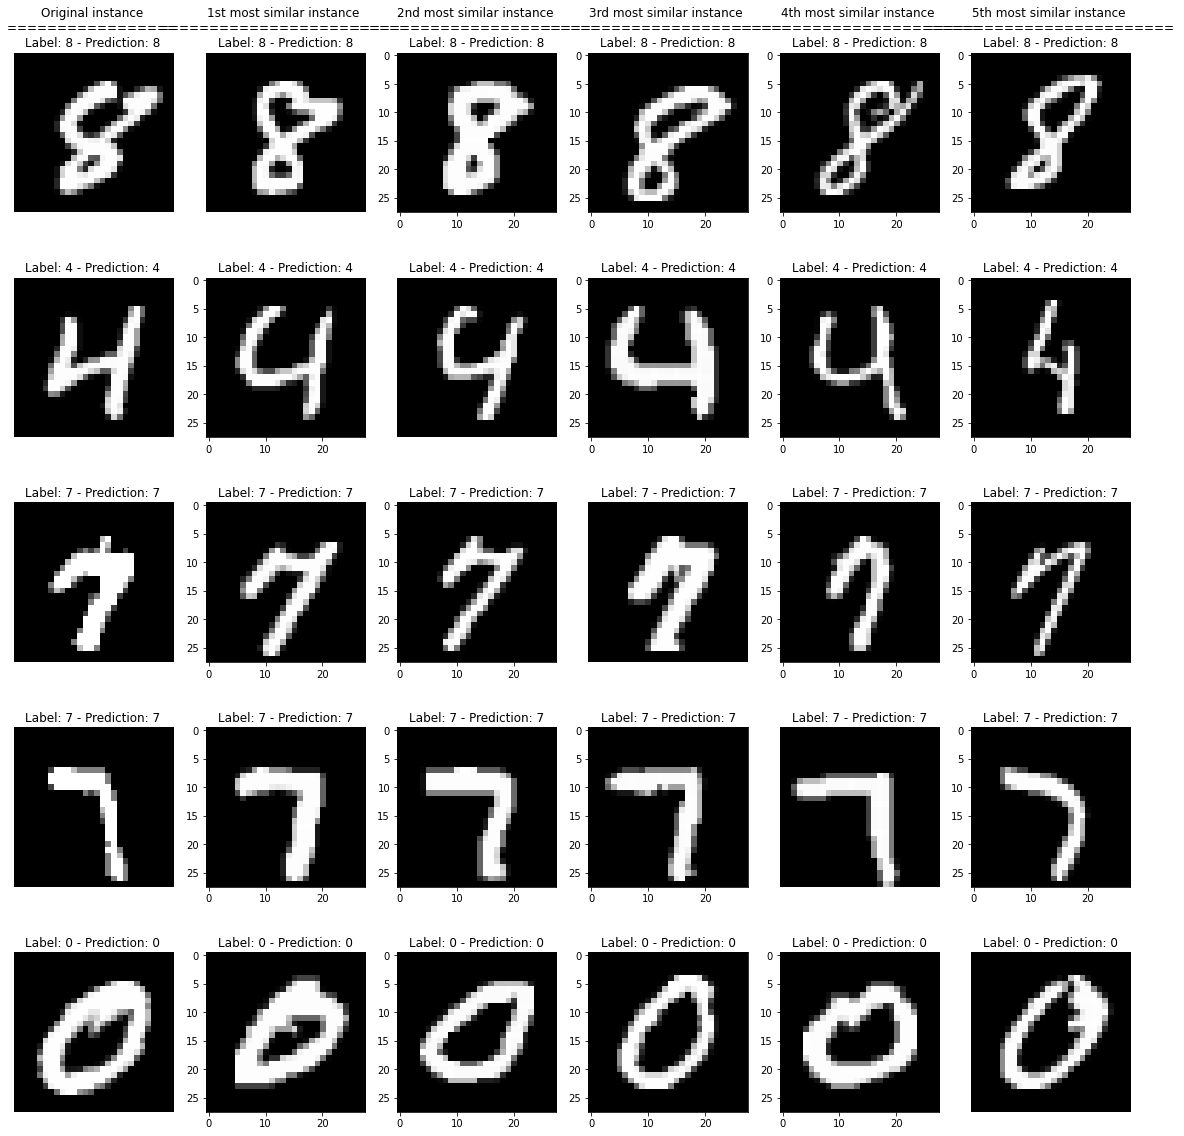

In [13]:
plot_similar(ds, expls)

### Most similar labels distributions 

Showing the average similarity scores for each group of instances in the reference set belonging to the same true class and to same predicted class. 

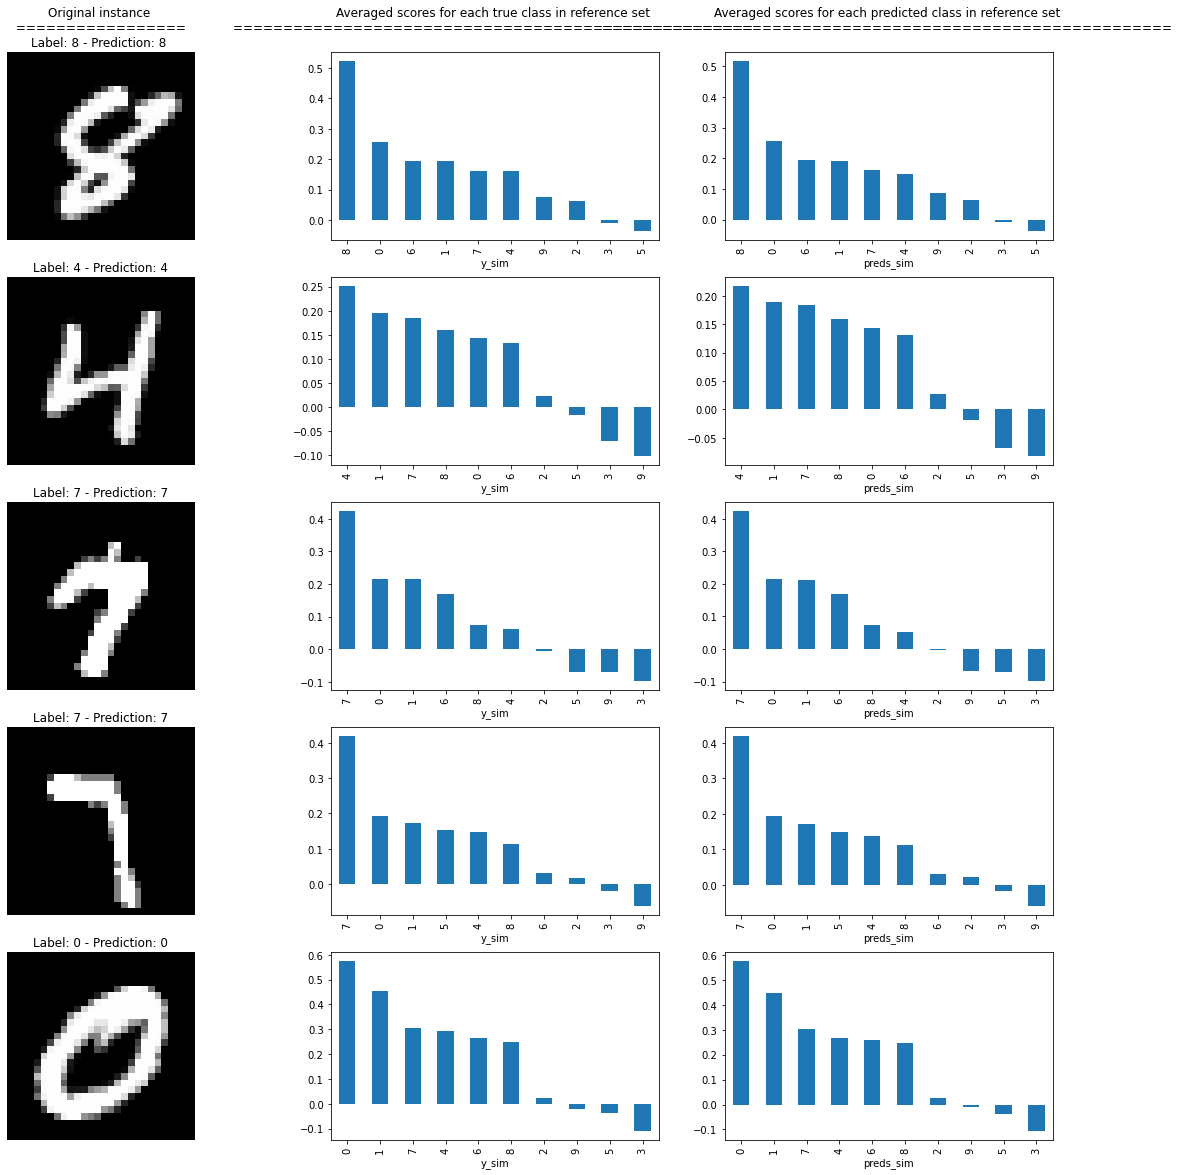

In [14]:
plot_distributions(ds, expls)

The plots show how the instances belonging to the same class (and the instances classified by the model as belonging to the same class) of the instance of interest  have on average higher similarity scores, as expected. 